# Lab 6 — Stochastic Approximation and PyTorch

In this lab we study **stochastic approximation**—a family of methods that replace exact expectations with **sample-based updates**.

## 🎯 Objectives
- Understand **Robbins–Monro** stochastic approximation and its link to mean estimation.
- Implement **SGD (single-sample updates)** in NumPy/PyTorch.
- Use **PyTorch autograd** to avoid manual gradient code.
- Extend SGD to **mini-batch (batched) SGD** and compare behaviors.

### Part I: Averaging Update Rule

We start from the recursive update:

$
w_{k+1} = w_k - \frac{1}{k}\bigl(w_k - x_k\bigr)
$


In [ ]:
import numpy as np

# generate some random data samples
np.random.seed(0)
x = np.random.randn(10)
print("Samples:", np.round(x, 3))

# initialize
w = 0.0
w_list = []

# recursive averaging using the update rule
for k in range(1, len(x)+1):

    # Your time to work on it !

    w = #


    w_list.append(w)

# direct averages for comparison
mean_list = [np.mean(x[:k]) for k in range(1, len(x)+1)]

# compare both sequences
print("\nStep | Recursive w_k | Direct mean")
print("-"*35)
for k, (wk, mk) in enumerate(zip(w_list, mean_list), 1):
    print(f"{k:>4} | {wk:>13.6f} | {mk:>13.6f}")


Samples: [ 1.764  0.4    0.979  2.241  1.868 -0.977  0.95  -0.151 -0.103  0.411]

Step | Recursive w_k | Direct mean
-----------------------------------
   1 |      1.764052 |      1.764052
   2 |      1.082105 |      1.082105
   3 |      1.047649 |      1.047649
   4 |      1.345960 |      1.345960
   5 |      1.450280 |      1.450280
   6 |      1.045687 |      1.045687
   7 |      1.032030 |      1.032030
   8 |      0.884107 |      0.884107
   9 |      0.774404 |      0.774404
  10 |      0.738023 |      0.738023


## Part II: Robbins–Monro Algorithm — Convergence Example

We now illustrate the **Robbins–Monro stochastic approximation algorithm**.

The goal is to find the root $x^\star$ of an unknown function $g(x)$ such that $
g(x^\star) = 0$.

---

### Example Setup

- $ g(x) = \tanh(x - 1) $
- True root: $ x^\star = 1 $
- Step size: $ a_k = \frac{1}{k} $
- Noiseless case: $ \eta_k = 0 $

Then the Robbins–Monro update becomes:

$
w_{k+1} = w_k - a_k g(w_k)
$

or explicitly,

$
w_{k+1} = w_k - \frac{1}{k} \tanh(w_k - 1).
$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Robbins–Monro parameters
def g(x):
    return np.tanh(x - 1)

def robbins_monro(w0=3.0, steps=100):
    w = w0
    ws = [w]
    for k in range(1, steps + 1):

        # Your time to work on it
        a_k = #
        w = #

        ws.append(w)
    return np.array(ws)

ws = robbins_monro(w0=3.0, steps=100)

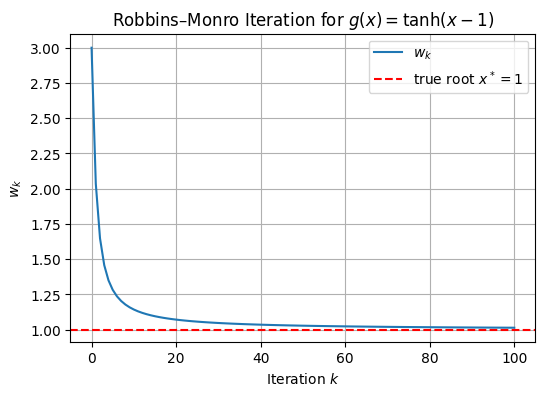

In [2]:
# Plot trajectory
plt.figure(figsize=(6,4))
plt.plot(ws, label=r"$w_k$")
plt.axhline(1.0, color='red', linestyle='--', label=r"true root $x^*=1$")
plt.xlabel("Iteration $k$")
plt.ylabel("$w_k$")
plt.title("Robbins–Monro Iteration for $g(x)=\\tanh(x-1)$")
plt.legend()
plt.grid(True)
plt.show()

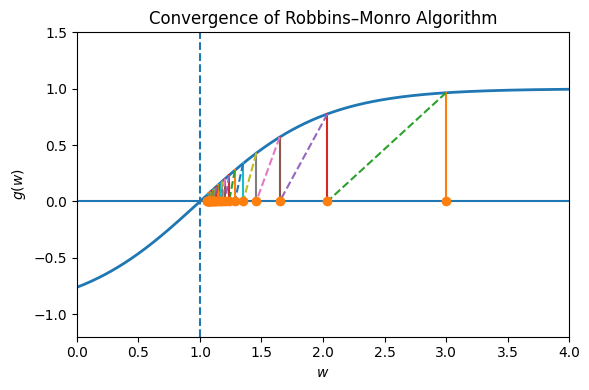

In [3]:
def robbins_monro_path(w0=3.0, steps=15):
    w = float(w0)
    ws = [w]
    segs = []  # list of ((x0,y0),(x1,y1)) segments for cobweb
    for k in range(1, steps+1):
        gw = g(w)
        # vertical up: (w_k, 0) -> (w_k, g(w_k))
        segs.append(((w, 0.0), (w, gw)))
        # horizontal/diagonal back to axis: (w_k, g(w_k)) -> (w_{k+1}, 0)
        a_k = 1.0 / k
        w_next = w - a_k * gw
        segs.append(((w, gw), (w_next, 0.0)))
        w = w_next
        ws.append(w)
    return np.array(ws), segs

# Build trajectory
ws, segs = robbins_monro_path(w0=3.0, steps=25)

# Plot g(w)
wgrid = np.linspace(0, 4, 400)
plt.figure(figsize=(6,4))
plt.plot(wgrid, g(wgrid), linewidth=2)

# Axes lines and true root
plt.axhline(0.0, linestyle='-')
plt.axvline(1.0, linestyle='--')

# Cobweb segments
for (x0,y0),(x1,y1) in segs:
    # up to curve
    if y1 != 0.0:
        plt.plot([x0,x1],[y0,y1], linestyle='-')
    # down to axis
    else:
        plt.plot([x0,x1],[y0,y1], linestyle='--')

# Mark w_k points on the axis
plt.plot(ws, np.zeros_like(ws), marker='o', linestyle='')

# Labels / limits
plt.xlabel("$w$")
plt.ylabel("$g(w)$")
plt.title(r"Convergence of Robbins–Monro Algorithm")
plt.xlim(0,4)
plt.ylim(-1.2,1.5)
plt.tight_layout()
plt.show()


## Part III: Full Gradient Descent

We consider
$$
J(\mathbf w)=\mathbb E\!\left[\tfrac12\lVert \mathbf w-\mathbf X\rVert^2\right],
\qquad
f(\mathbf w,\mathbf X)=\tfrac12\lVert \mathbf w-\mathbf X\rVert^2,
\qquad
\nabla_{\mathbf w} f(\mathbf w,\mathbf X)=\mathbf w-\mathbf X.
$$


This formulation can be interpreted as a **mean estimation problem** under a **Gaussian distribution**:
- Suppose the random variable $\mathbf X \sim \mathrm{Normal}(\boldsymbol\mu, \Sigma)$.
- The goal is to find a parameter vector $\mathbf w$ that minimizes the *expected squared distance* between $\mathbf w$ and samples $\mathbf X$.
- The function $f(\mathbf w, \mathbf X)$ measures the instantaneous “cost” of choosing $\mathbf w$ when the observed sample is $\mathbf X$.
- The expected loss $J(\mathbf w)$ is minimized when $\mathbf w$ equals the **true mean** $\boldsymbol\mu$.



Since the expectation is over $\mathbf X$,
$$
\nabla J(\mathbf w)=\mathbb E[\mathbf w-\mathbf X]=\mathbf w-\boldsymbol\mu,
\quad\text{where } \boldsymbol\mu=\mathbb E[\mathbf X].
$$

Thus \(J\) is minimized at
$$
\mathbf w^\star=\boldsymbol\mu.
$$

**Full (deterministic) GD** with step size $\eta>0$:
$$
\mathbf w_{k+1}
= \mathbf w_k - \eta\,(\mathbf w_k-\boldsymbol\mu)
= (1-\eta)\,\mathbf w_k + \eta\,\boldsymbol\mu .
$$

In [4]:
import numpy as np
import matplotlib.pyplot as plt

mu = np.array([1.5, 0.7])   # true mean
eta = 0.3                   # step size, must satisfy 0 < eta < 2
w0 = np.array([3.0, -1.5])  # starting point
steps = 7

def J(w, mu):
    return 0.5*np.sum((w - mu)**2)

# run GD
ws = [w0.copy()]
w = w0.copy()
for k in range(steps):

    # Your time to work on it
    grad =            # ∇J(w) = w - μ
    w = #
    ws.append(w.copy())
ws = np.array(ws)

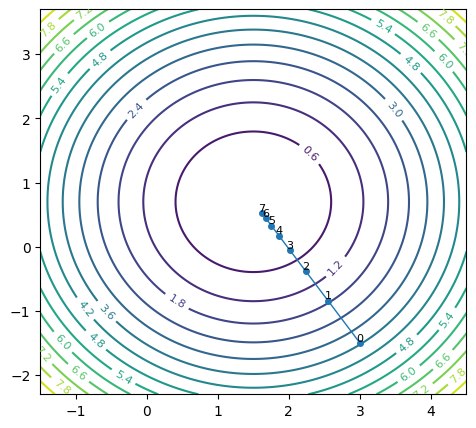

In [5]:
# Plotting functions
xx = np.linspace(mu[0]-3.0, mu[0]+3.0, 201)
yy = np.linspace(mu[1]-3.0, mu[1]+3.0, 201)
XX, YY = np.meshgrid(xx, yy)
ZZ = 0.5*((XX-mu[0])**2 + (YY-mu[1])**2)
plt.figure(figsize=(5.5,5))
CS = plt.contour(XX, YY, ZZ, levels=15)
plt.clabel(CS, inline=1, fontsize=8)

plt.plot(ws[:,0], ws[:,1], marker='o', linewidth=1, ms=4)

for i in range(len(ws)):
    plt.text(ws[i,0], ws[i,1], str(i), fontsize=8, ha='center', va='bottom')

## Part IV: Stochastic Gradient Descent (SGD)

### 🧩 Step 1: Sampling Data Points

In practice, we often **don’t have access to the full function or distribution** that generates our data — we only observe **samples** drawn from it.  For example, in machine learning we never know the *true* relationship between inputs and outputs; we only get data points collected from the real world.

To mimic this situation, we generate **40 random data samples** from a **2D Gaussian distribution** with a known (but hidden) true mean.  
Our goal later will be to estimate this mean using **Stochastic Gradient Descent (SGD)**, as if we didn’t know it beforehand.

In [6]:
# ----- 1) Sample 40 points -----
np.random.seed(7)
mu_true = np.array([1.5, 0.7])
Sigma = np.array([[0.5, 0.2],
                  [0.2, 0.3]])
N = 40
X = np.random.multivariate_normal(mu_true, Sigma, size=N)
X_bar = X.mean(axis=0)

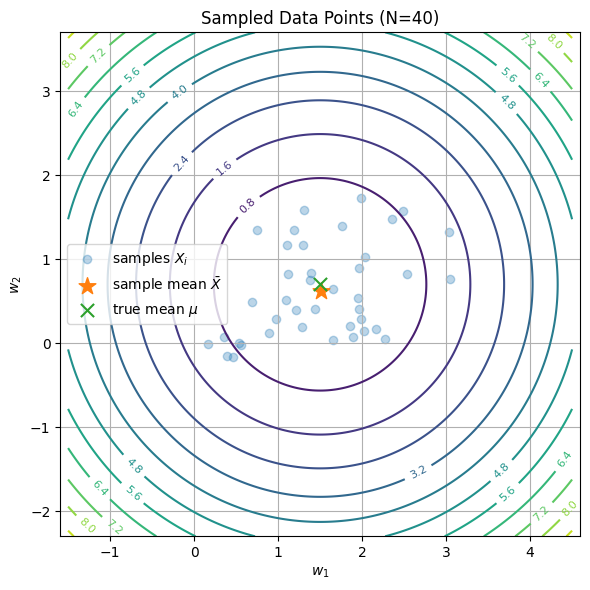

In [7]:
# ----- 2) Plot dataset, contours -----
plt.figure(figsize=(6,6))
cs = plt.contour(xx, yy, ZZ, levels=12)
plt.clabel(cs, inline=1, fontsize=8)

# data points and means
plt.scatter(X[:,0], X[:,1], alpha=0.3, label="samples $X_i$")
plt.scatter(X_bar[0], X_bar[1], marker="*", s=160, label="sample mean $\\bar X$")
plt.scatter(mu_true[0], mu_true[1], marker="x", s=90, label="true mean $\\mu$")


plt.title("Sampled Data Points (N=40)")
plt.xlabel("$w_1$"); plt.ylabel("$w_2$")
plt.axis("equal"); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

### 🧩 Step 2: Stochastic Gradient Descent
However, in practice we only observe one sample $\mathbf X_i$ at a time.  
To approximate the gradient, we use the **instantaneous gradient** from that single sample:

$
\nabla_{\mathbf w} f(\mathbf w, \mathbf X_i) = \mathbf w - \mathbf X_i.
$

Then, we update the parameter using the SGD rule:

$
\mathbf w_{t+1} = \mathbf w_t - \eta \, (\mathbf w_t - \mathbf X_i),
$

where $\eta > 0$ is the **learning rate** that controls the step size.

In [8]:
eta = 0.3           # 0 try 0.3 or 0.9 to see different behavior
epochs = 1

w = w0.copy()
ws = [w.copy()]
loss_hist = []

rng = np.random.default_rng(0)
for ep in range(epochs):
    idx = np.arange(N)
    #rng.shuffle(idx) # pick a random data
    for i in idx:

        # Your time to work on it
        grad_i =          # ∇(1/2)||w - X_i||^2
        w =               #
        ws.append(w.copy())



ws = np.array(ws)

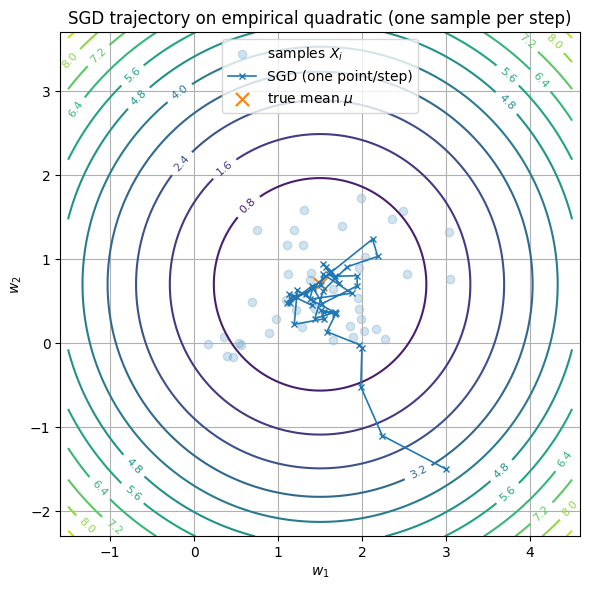

In [9]:
plt.figure(figsize=(6,6))
cs = plt.contour(xx, yy, ZZ, levels=12)
plt.clabel(cs, inline=1, fontsize=8)

plt.scatter(X[:,0], X[:,1], alpha=0.2, label="samples $X_i$")
plt.plot(ws[:,0], ws[:,1], marker='x', ms=5, linewidth=1.2, label="SGD (one point/step)")
plt.scatter(mu_true[0], mu_true[1], marker="x", s=90, label="true mean $\\mu$")

plt.title("SGD trajectory on empirical quadratic (one sample per step)")
plt.xlabel("$w_1$"); plt.ylabel("$w_2$")
plt.axis("equal"); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

### ⚙️ Part V: Using PyTorch — no manual gradients needed for SDG

With **PyTorch autograd**, we don’t hand-derive or code gradients like $\nabla_{\mathbf w} f(\mathbf w,\mathbf X)=\mathbf w-\mathbf X$.  
Instead, we **build the computation with tensors**, and PyTorch computes gradients automatically via **reverse-mode autodiff**.


In [13]:
import torch
# Torch tensors
device = "cpu"
X_torch = torch.from_numpy(X).float().to(device)
X_bar = X_torch.mean(dim=0)

# w become the parameter we want to estimate (2D)
w = torch.nn.Parameter(torch.tensor([3.0, -1.5], dtype=torch.float32, device=device))

# One-sample-at-a-time SGD (you can also use torch.optim.SGD with batch_size=1; here we show manual control)
eta = 0.3
epochs = 1

# Hyperparameters
eta = 0.1
epochs = 3  # how many times we loop through the dataset
ws = []     # record trajectory

for epoch in range(epochs):
    # shuffle the data order at each epoch
    indices = torch.arange(N)
    #indices = torch.randperm(len(X_torch))

    for i in indices:
        Xi = X_torch[i]

        # Your time to work on it

        loss = # loss = 0.5 * ||w - Xi||^2
        loss.backward()

        # SGD update
        with torch.no_grad():
            w -= eta * w.grad    # loss.backward() + w.grad gives you the gradient

        # clear gradient buffer
        w.grad.zero_()
        # record current w for visualization
        ws.append(w.detach().clone())
ws = torch.stack(ws).numpy()

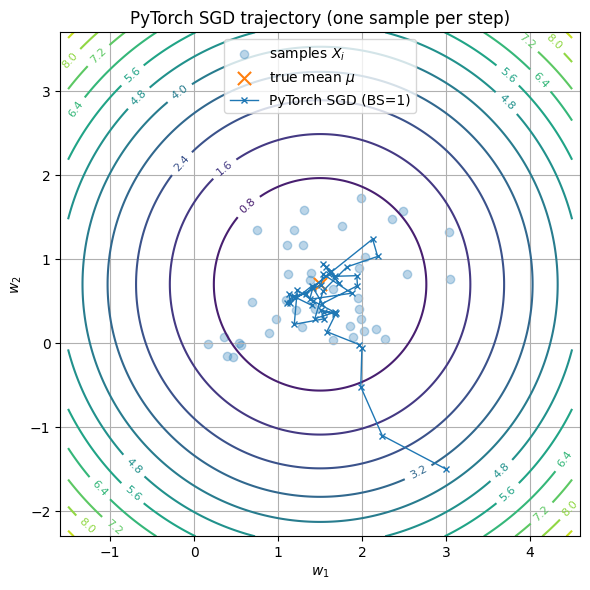

In [12]:
plt.figure(figsize=(6,6))
cs = plt.contour(xx, yy, ZZ, levels=12)
plt.clabel(cs, inline=1, fontsize=8)
plt.scatter(X[:,0], X[:,1], alpha=0.3, label="samples $X_i$")
plt.scatter(mu_true[0], mu_true[1], marker="x", s=90, label="true mean $\\mu$")
plt.plot(ws[:,0], ws[:,1], marker='x', ms=4, linewidth=1., label="PyTorch SGD (BS=1)")
plt.title("PyTorch SGD trajectory (one sample per step)")
plt.xlabel("$w_1$"); plt.ylabel("$w_2$")
plt.axis("equal"); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()


### 📦 Part VI: Batched SDG and Pytorch Optimizer

To reduce the variance of single-sample updates and better utilize vectorized compute, we switch from **one-sample SGD** to **mini-batch SGD**:

- Use a **DataLoader** to iterate over **batches of 4 samples**.
- Define the mini-batch loss as  
  $
  \frac{1}{B}\sum_{i=1}^{B} \tfrac12 \lVert \mathbf w - \mathbf X_i \rVert^2,
  $
  i.e., average of per-sample squared distances in the batch.
- Let PyTorch handle gradients and updates via **`torch.optim.SGD`**.
- Record $ \mathbf w $ after each optimizer step for visualization later.

This keeps the same objective (estimating the Gaussian mean) while making updates **more stable** than single-sample SGD.


In [14]:
# ----- Batched SGD with batch_size=4 using torch.optim.SGD -----

from torch.utils.data import TensorDataset, DataLoader

device = "cpu"

# Assume X (Nx2 numpy) and mu_true, N are already defined
X_torch = torch.from_numpy(X).float().to(device)
X_bar   = X_torch.mean(dim=0)

# Parameter to estimate (2D mean)
w = torch.nn.Parameter(torch.tensor([3.0, -1.5], dtype=torch.float32, device=device))

# DataLoader for mini-batch sampling
batch_size = 4
dataset = TensorDataset(X_torch)                 # each item is (Xi,)
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

# Optimizer hyperparams
eta    = 0.1
epochs = 4
opt    = torch.optim.SGD([w], lr=eta) # we now use an optimizer to update w

# record trajectory of w
ws = []

for epoch in range(epochs):
    for (Xb,) in loader:  # Xb: [B, 2]
        # Mini-batch loss: average of 0.5 * ||w - Xi||^2 over the batch
        # Broadcast w (2,) against Xb (B,2) -> per-sample squared norms then mean
        per_sample = 0.5 * torch.sum((w - Xb) ** 2, dim=1)
        loss = per_sample.mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        ws.append(w.detach().clone())

ws = torch.stack(ws).cpu().numpy()

print("Final estimate (w):", w.detach().cpu().numpy())
print("Sample mean (X_bar):", X_bar.detach().cpu().numpy())
print("True mean (mu_true):", mu_true)


Final estimate (w): [1.4963852 0.5836901]
Sample mean (X_bar): [1.5049709 0.6171909]
True mean (mu_true): [1.5 0.7]


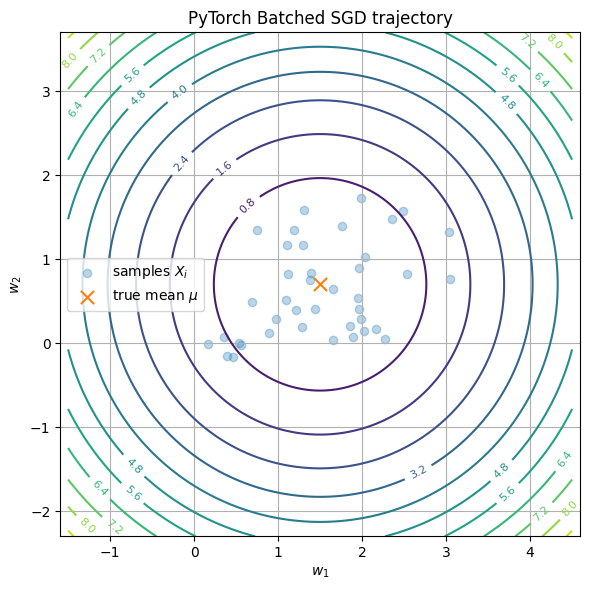

In [16]:
plt.figure(figsize=(6,6))
cs = plt.contour(xx, yy, ZZ, levels=12)
plt.clabel(cs, inline=1, fontsize=8)
plt.scatter(X[:,0], X[:,1], alpha=0.3, label="samples $X_i$")
plt.scatter(mu_true[0], mu_true[1], marker="x", s=90, label="true mean $\\mu$")
plt.title("PyTorch Batched SGD trajectory")
plt.xlabel("$w_1$"); plt.ylabel("$w_2$")
plt.axis("equal"); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

## 🧩 Part VII: MNIST with Mini-batch SGD (PyTorch)

In this example, you’ll train a simple classifier on **MNIST** using **mini-batch SGD**.
We’ll use:
- `DataLoader` (mini-batches, shuffling),
- a small **CNN** (or switch to MLP if you prefer),
- `torch.optim.SGD` (tweak `lr`, `momentum`, `batch_size`),
- a standard **train / eval** loop with accuracy reporting.

**Try:** compare `batch_size ∈ {1, 32, 128}`, change `lr`, and toggle `momentum` to see stability and speed differences.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import os

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)   # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 14x14 -> 14x14
        self.fc1   = nn.Linear(32*7*7, 64)
        self.fc2   = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))         # [B,16,28,28]
        x = F.max_pool2d(x, 2)            # [B,16,14,14]
        x = F.relu(self.conv2(x))         # [B,32,14,14]
        x = F.max_pool2d(x, 2)            # [B,32,7,7]
        x = x.view(x.size(0), -1)         # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SmallCNN().to(device)

In [ ]:
# ----- Train / Eval Loops -----
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # Your time to work on it
        # forward
        # .....

        # backward + sgd step
        # .....

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss / total, total_correct / total

In [ ]:
# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----- Data -----
# Normalize to mean=0.1307, std=0.3081 (standard for MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root="./data", train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256,    shuffle=False, num_workers=2, pin_memory=True)


lr = 0.1
momentum = 0.0   # try 0.9 later for smoother updates
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 3
for ep in range(1, epochs+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    te_loss, te_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {ep:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc*100:5.2f}%  | "
          f"test loss {te_loss:.4f} acc {te_acc*100:5.2f}%")
